In [1]:
import astropy
import astroplan
from astroplan import Observer, FixedTarget
from astroplan.constraints import AtNightConstraint, AirmassConstraint, MoonSeparationConstraint, TimeConstraint
from astroplan import ObservingBlock
from astroplan import Transitioner
from astroplan.scheduling import Schedule
from astroplan.scheduling import SequentialScheduler
from astropy.coordinates import SkyCoord
from astroplan.scheduling import PriorityScheduler
from astroplan.plots import plot_schedule_airmass
from astropy.time import Time
import matplotlib.pyplot as plt
import astropy.units as u

#I am following along with this tutorial just to figure out what is going on:
#https://astroplan.readthedocs.io/en/latest/tutorials/scheduling.html

In [2]:
#I looked at the site available on astroplan
astropy.coordinates.EarthLocation.get_site_names()
#from this list, it looks like we need to add Bigelow and Lemmon. 
#One can submit a pull request to the astropy-data repository 
#Look under get_site_names here:
#http://docs.astropy.org/en/stable/api/astropy.coordinates.EarthLocation.html#astropy.coordinates.EarthLocation.get_site_names

[u'',
 u'',
 u'',
 u'ALMA',
 u'Anglo-Australian Observatory',
 u'Apache Point',
 u'Apache Point Observatory',
 u'Atacama Large Millimeter Array',
 u'BAO',
 u'Beijing XingLong Observatory',
 u'Black Moshannon Observatory',
 u'CHARA',
 u'Canada-France-Hawaii Telescope',
 u'Catalina Observatory',
 u'Cerro Pachon',
 u'Cerro Paranal',
 u'Cerro Tololo',
 u'Cerro Tololo Interamerican Observatory',
 u'DCT',
 u'Discovery Channel Telescope',
 u'Dominion Astrophysical Observatory',
 u'GBT',
 u'Gemini South',
 u'Green Bank Telescope',
 u'Hale Telescope',
 u'Haleakala Observatories',
 u'Happy Jack',
 u'IAO',
 u'JCMT',
 u'James Clerk Maxwell Telescope',
 u'Jansky Very Large Array',
 u'Keck Observatory',
 u'Kitt Peak',
 u'Kitt Peak National Observatory',
 u'La Silla Observatory',
 u'Large Binocular Telescope',
 u'Las Campanas Observatory',
 u'Lick Observatory',
 u'Lowell Observatory',
 u'MWA',
 u'Manastash Ridge Observatory',
 u'McDonald Observatory',
 u'Medicina',
 u'Medicina Dish',
 u'Michigan-Dart

In [5]:
kpno = Observer.at_site('kpno')

M31 = FixedTarget.from_name('M31')
print M31

SN2019np = FixedTarget(coord=SkyCoord(ra=157.341500*u.deg, dec=29.510667*u.deg),name='SN2019np')
print SN2019np

noon_before = Time('2019-02-19 19:00')
noon_after = Time('2019-02-20 19:00')

<FixedTarget "M31" at SkyCoord (ICRS): (ra, dec) in deg (10.6847083, 41.26875)>
<FixedTarget "SN2019np" at SkyCoord (ICRS): (ra, dec) in deg (157.3415, 29.510667)>


In [12]:
# create the list of constraints that all targets must satisfy
#global_constraints = [AirmassConstraint(max = 2.5, boolean_constraint = False),
#                       AtNightConstraint.twilight_civil(), MoonSeparationConstraint(min=30.*u.deg)]
                          # create the list of constraints that all targets must satisfy
global_constraints = [AirmassConstraint(max = 2.5, boolean_constraint = False),
                           AtNightConstraint.twilight_civil()]
                          

In [13]:
read_out = 35 * u.second
M31_exp = 15.*u.second
SN2019np_exp = 300.*u.second

M31_n = 5
SN2019np_n = 8

blocks = []

night_start = Time('2019-02-20 02:37')
night_end = Time('2019-02-20 12:43')

tonight = TimeConstraint(night_start, night_end)

# Create ObservingBlocks for each filter and target with our time
# constraint, and durations determined by the exposures needed


for priority, bandpass in enumerate(['U', 'B', 'V', 'R', 'I']):
    # We want each filter to have separate priority (so that target
    # and reference are both scheduled)
    #DS note:  We will want to change this at some point.
    
    b = ObservingBlock.from_exposures(M31, priority, M31_exp, M31_n, read_out,
                                            configuration = {'filter': bandpass},
                                            constraints = [tonight])
    blocks.append(b)
    b = ObservingBlock.from_exposures(SN2019np, priority, SN2019np_exp, SN2019np_n, read_out,
                                             configuration = {'filter': bandpass},
                                             constraints = [tonight])
    blocks.append(b)
    


In [14]:
# Initialize a transitioner object with the slew rate and/or the
# duration of other transitions (e.g. filter changes)
slew_rate = .8*u.deg/u.second
transitioner = Transitioner(slew_rate,
                                {'filter':{('B','V'): 10*u.second,
                                           ('V','R'): 10*u.second,
                                            'default': 30*u.second}})
print 'hello'

hello


In [15]:
seq_scheduler = SequentialScheduler(constraints = global_constraints,
                                         observer = kpno,
                                         transitioner = transitioner)

#sequential_schedule = Schedule(noon_before, noon_after)
#seq_scheduler(blocks, sequential_schedule)
print 'yoyo'

yoyo


In [16]:
# Initialize the priority scheduler with the constraints and transitioner
prior_scheduler = PriorityScheduler(constraints = global_constraints,
                                         observer = kpno,
                                         transitioner = transitioner)
# Initialize a Schedule object, to contain the new schedule
priority_schedule = Schedule(noon_before, noon_after)

# Call the schedule with the observing blocks and schedule to schedule the blocks
prior_scheduler(blocks, priority_schedule)

priority_schedule.to_table()

target,start time (UTC),end time (UTC),duration (minutes),ra,dec,configuration
unicode15,str23,str23,float64,unicode32,unicode32,object
M31,2019-02-20 02:37:00.017,2019-02-20 02:41:20.017,4.3333333333334245,10.6847083,41.26875,{'filter': 'U'}
TransitionBlock,2019-02-20 02:41:20.017,2019-02-20 02:42:00.017,0.6666666666665577,,,[u'filter:U to B']
M31,2019-02-20 02:42:00.017,2019-02-20 02:46:20.017,4.333333333333265,10.6847083,41.26875,{'filter': 'B'}
TransitionBlock,2019-02-20 02:46:20.017,2019-02-20 02:46:40.017,0.33333333333327886,,,[u'filter:B to V']
M31,2019-02-20 02:46:40.017,2019-02-20 02:51:00.017,4.333333333333265,10.6847083,41.26875,{'filter': 'V'}
TransitionBlock,2019-02-20 02:51:00.017,2019-02-20 02:51:20.017,0.33333333333327886,,,[u'filter:V to R']
M31,2019-02-20 02:51:20.017,2019-02-20 02:55:40.017,4.333333333333265,10.6847083,41.26875,{'filter': 'R'}
TransitionBlock,2019-02-20 02:55:40.017,2019-02-20 02:56:20.017,0.6666666666665577,,,[u'filter:R to I']
M31,2019-02-20 02:56:20.017,2019-02-20 03:00:40.017,4.333333333333265,10.6847083,41.26875,{'filter': 'I'}


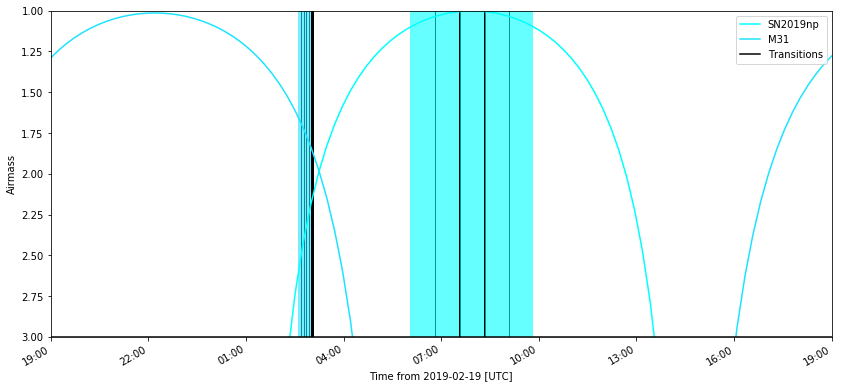

In [17]:
# plot the schedule with the airmass of the targets
plt.figure(figsize = (14,6))
plot_schedule_airmass(priority_schedule)
plt.legend(loc = "upper right")
plt.show()